# crab age prediction with EDA and XGB baseline!
modified from: https://www.kaggle.com/code/kimtaehun/crab-age-prediction-with-eda-and-xgb-baseline

Purpose: to predict age of crab
Motivation: For a commercial crab farmer knowing the right age of the crab helps them decide if and when to harvest the crabs. Beyond a certain age, there is negligible growth in crab's physical characteristics and hence, it is important to time the harvesting to reduce cost and increase profit.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc

from tqdm.auto import tqdm # a progress meter
import math
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV
import warnings
warnings.filterwarnings('ignore')


#from lightgbm import LGBMRegressor # LightGBM is a gradient boosting framework that uses tree based learning algorithms
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

tqdm.pandas()

rc = {
    "axes.facecolor": "#FFF9ED",
    "figure.facecolor": "#FFF9ED",
    "axes.edgecolor": "#000000",
    "grid.color": "#EBEBE7",
    "font.family": "serif",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4
}

sns.set(rc=rc)

from colorama import Style, Fore
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
mgt = Style.BRIGHT + Fore.MAGENTA
gld = Style.BRIGHT + Fore.YELLOW
res = Style.RESET_ALL

In [8]:
# load data
train = pd.read_csv("/home/sylvanix/data/Crab_Age_Prediction/train.csv")
test = pd.read_csv("/home/sylvanix/data/Crab_Age_Prediction/test.csv")

### EDA

In [9]:
# summary table function
def summary(df):
    # Print the shape of the DataFrame
    print(f'data shape: {df.shape}')  
    # Create a summary DataFrame
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    # Calculate the number of missing values
    summ['#missing'] = df.isnull().sum().values 
    # Calculate the percentage of missing values
    summ['%missing'] = df.isnull().sum().values / len(df)* 100
    # Calculate the number of unique values
    summ['#unique'] = df.nunique().values
    # Create a descriptive DataFrame
    desc = pd.DataFrame(df.describe(include='all').transpose())
    # Add the minimum, maximum, and first three values to the summary DataFrame
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    summ['first value'] = df.loc[0].values
    summ['second value'] = df.loc[1].values
    summ['third value'] = df.loc[2].values
    
    # Return the summary DataFrame
    return summ

summary(train)

data shape: (74051, 10)


data type  #missing  %missing  #unique       min        max   
id                 int64         0       0.0    74051       0.0    74050.0  \
Sex               object         0       0.0        3       NaN        NaN   
Length           float64         0       0.0      144    0.1875   2.012815   
Diameter         float64         0       0.0      122    0.1375     1.6125   
Height           float64         0       0.0       65       0.0      2.825   
Weight           float64         0       0.0     3096  0.056699  80.101512   
Shucked Weight   float64         0       0.0     1766  0.028349  42.184056   
Viscera Weight   float64         0       0.0      967  0.042524   21.54562   
Shell Weight     float64         0       0.0     1048  0.042524  28.491248   
Age                int64         0       0.0       28       1.0       29.0   

               first value second value third value  
id                       0            1           2  
Sex                      I            I           M  
Length               1.525          1.1      1.3875  
Diameter             1.175        0.825      1.1125  
Height               0.375        0.275       0.375  
Weight           28.973189    10.418441   24.777463  
Shucked Weight   12.728926     4.521745     11.3398  
Viscera Weight    6.647958     2.324659    5.556502  
Shell Weight      8.348928      3.40194    6.662133  
Age                      9            8           9

No missing values... noice!

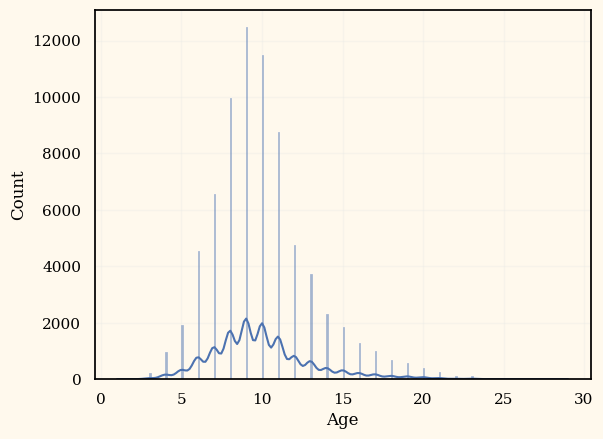

In [10]:
# select numerical and categorical variables respectively.
num_cols = test.select_dtypes(include=['float64']).columns.tolist()
cat_cols = test.select_dtypes(include=['object']).columns.tolist()
all_features = num_cols + cat_cols

# let's check the distribution of target variable

sns.histplot(train, x="Age", kde=True)
plt.show()

Ages look to be normally distributed without outliers.

**Now check numerical variables' distributions**

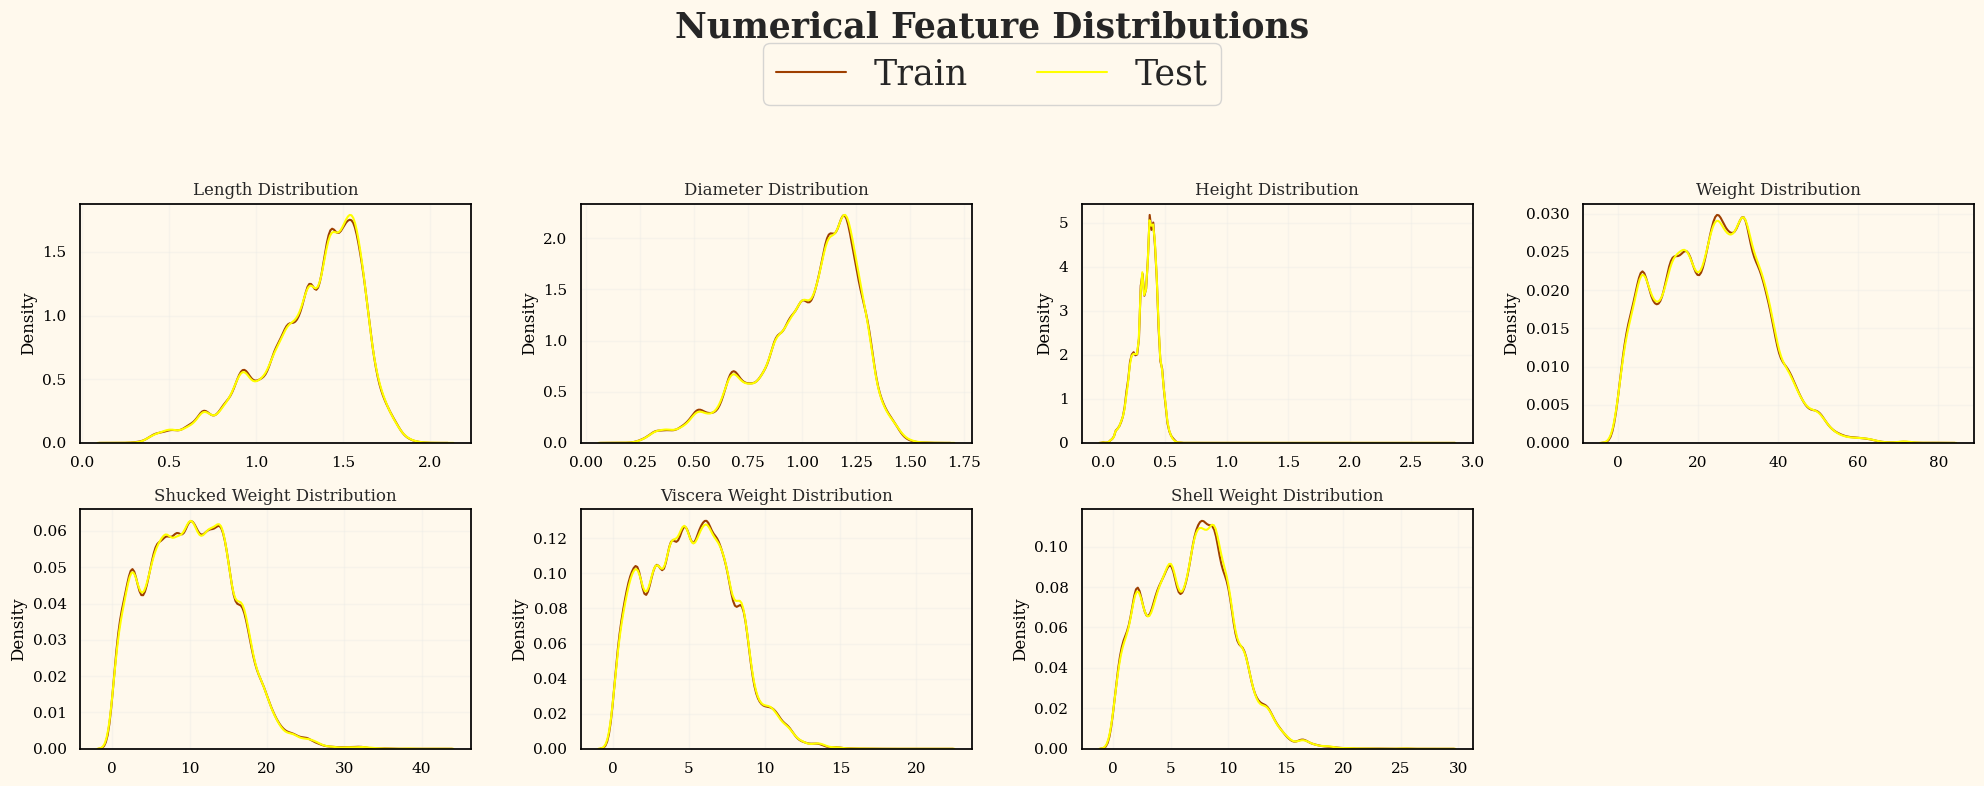

In [13]:
features = num_cols
n_bins = 50
histplot_hyperparams = {
    'kde':True,
    'alpha':0.4,
    'stat':'percent',
    'bins':n_bins
}

columns = features
n_cols = 4
n_rows = math.ceil(len(columns)/n_cols)
fig, ax = plt.subplots(n_rows, n_cols, figsize=(20, n_rows*4))
ax = ax.flatten()

for i, column in enumerate(columns):
    plot_axes = [ax[i]]
    sns.kdeplot(
        train[column], label='Train',
        ax=ax[i], color='#9E3F00'
    )
    
    sns.kdeplot(
        test[column], label='Test',
        ax=ax[i], color='yellow'
    )
    
    
    # titles
    ax[i].set_title(f'{column} Distribution');
    ax[i].set_xlabel(None)
    
    # remove axes to show only one at the end
    plot_axes = [ax[i]]
    handles = []
    labels = []
    for plot_ax in plot_axes:
        handles += plot_ax.get_legend_handles_labels()[0]
        labels += plot_ax.get_legend_handles_labels()[1]
        plot_ax.legend().remove()
    
for i in range(i+1, len(ax)):
    ax[i].axis('off')
    
fig.suptitle(f'Numerical Feature Distributions\n\n\n', ha='center',  fontweight='bold', fontsize=25)
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.96), fontsize=25, ncol=3)
plt.tight_layout()

**Check distributions of categorical feature**

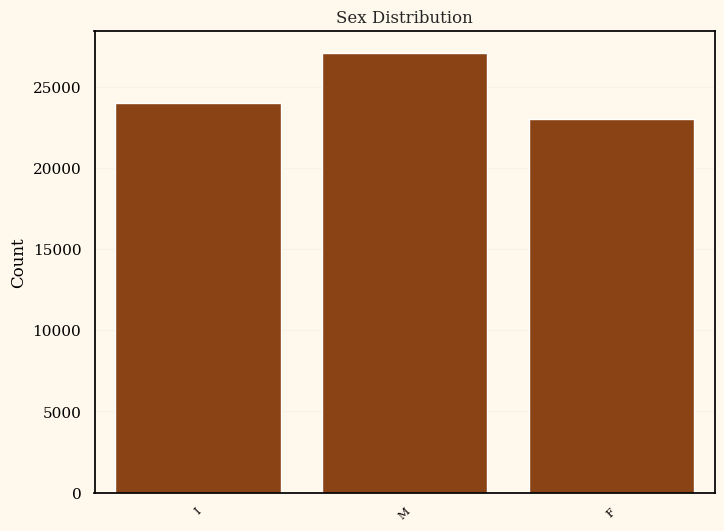

In [14]:
import math

def plot_categorical_distribution(data, column):
    plt.figure(figsize=(8, 6))
    sns.countplot(data=data, x=column, color='#9E3F00')
    plt.title(f'{column} Distribution')
    plt.xlabel(None)
    plt.ylabel('Count')
    plt.xticks(rotation=45, fontsize=8)
    plt.show()
# plot categorical variables

for col in cat_cols:
    plot_categorical_distribution(train, col)

**Check correlations**

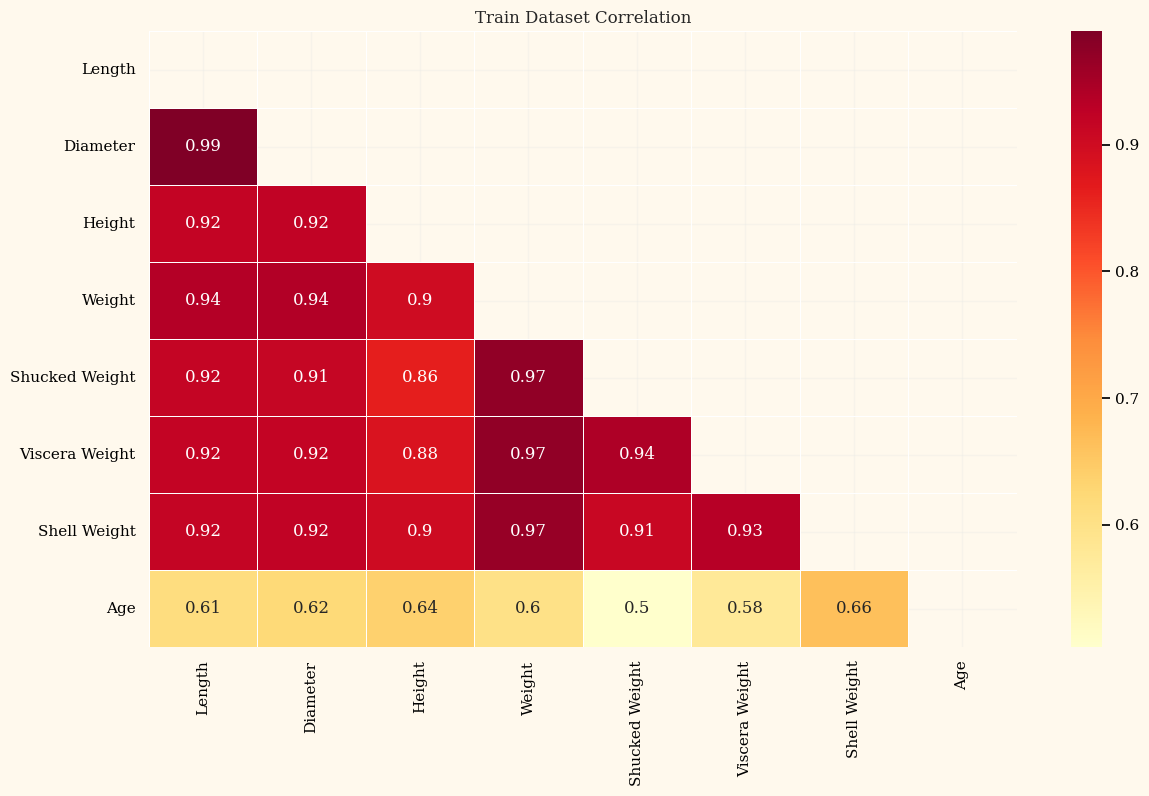

In [32]:
def plot_correlation_heatmap(df: pd.core.frame.DataFrame, title_name: str='Train correlation') -> None:
    corr = df.drop(['id', 'Sex'], axis=1).corr()
    fig, axes = plt.subplots(figsize=(14, 8))
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corr, mask=mask, linewidths=.5, cmap='YlOrRd', annot=True)
    plt.title(title_name)
    plt.show()

# plot_correlation_heatmap(original, 'Original Dataset Correlation')
plot_correlation_heatmap(train, 'Train Dataset Correlation')

### Preprocessing and Modeling

In [33]:
# simple preprocessing for categorical variable!
train = pd.get_dummies(train, columns=['Sex'])

from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

cv_scores = list()
importance_xgb = list()
preds = list()

# Assuming 'train_df' is your DataFrame, and 'Age' is your target column
X = train.drop('Age', axis=1)
Y = train['Age']

# Preprocess categorical columns
cat_cols = [] # fill in the list of your categorical variables
num_cols = [] # fill in the list of your numerical variables

for c in cat_cols:
    X[c] = X[c].astype('category')
    X[c] = X[c].cat.codes

## Running 3-fold CV
for i in range(3):
    print(f'\nFold {i+1} CV begins')
    skf = KFold(n_splits=3, random_state=np.random.randint(0,999), shuffle=True)
    
    for train_ix, test_ix in skf.split(X, Y):
        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
        Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]
                
        XGB_md = XGBRegressor(tree_method='gpu_hist',
                              objective='reg:squarederror',
                              colsample_bytree=0.8, 
                              gamma=0.8, 
                              learning_rate=0.01, 
                              max_depth=5, 
                              min_child_weight=10, 
                              n_estimators=1500, 
                              subsample=0.9).fit(X_train, Y_train)
        importance_xgb.append(XGB_md.feature_importances_)
        
        XGB_pred_1 = XGB_md.predict(X_test)
        mae = mean_absolute_error(Y_test, XGB_pred_1)
        cv_scores.append(mae)
        print(f'Fold {i+1} CV done. MAE: \033[1;36m{mae:.5f}\033[0m')

scores = np.mean(cv_scores)    
print(f'\nThe average MAE over 3-folds (run 3 times) is: \033[1;36m{scores:.5f}\033[0m')


Fold 1 CV begins
Fold 1 CV done. MAE: 1.40006
Fold 1 CV done. MAE: 1.39647
Fold 1 CV done. MAE: 1.40883

Fold 2 CV begins
Fold 2 CV done. MAE: 1.39658
Fold 2 CV done. MAE: 1.40646
Fold 2 CV done. MAE: 1.40484

Fold 3 CV begins
Fold 3 CV done. MAE: 1.40299
Fold 3 CV done. MAE: 1.40869
Fold 3 CV done. MAE: 1.39299

The average MAE over 3-folds (run 3 times) is: 1.40199


#### About Evaluation Metrics - MAE:

MAE, or Mean Absolute Error, is a metric for regression models. It's defined as the average of the absolute differences between the predicted and actual values. It measures the average magnitude of the errors in a set of predictions, without considering their direction.

Compared to other metrics:

    Mean Squared Error (MSE): MSE squares the errors before averaging them. This has the effect of giving more weight to larger errors. So, if your model makes a single very bad prediction, the MSE will be much higher than the MAE. MAE, on the other hand, treats all errors equally.

    Root Mean Squared Error (RMSE): RMSE is the square root of MSE. It also penalizes large errors more, but its units are the same as the original target, which can make it more interpretable than MSE.

    R-squared: Unlike MAE, MSE, and RMSE, R-squared is a relative measure of fit, and it tells you how much of the variance in the data is explained by the model. A higher R-squared indicates a better fit. It doesn't tell you how much the predictions differ from the actual values in absolute terms, like MAE does.

In summary, the choice of metric depends on your specific application. MAE is a good choice when you care equally about all errors, big and small. If you care more about large errors, you might prefer MSE or RMSE.

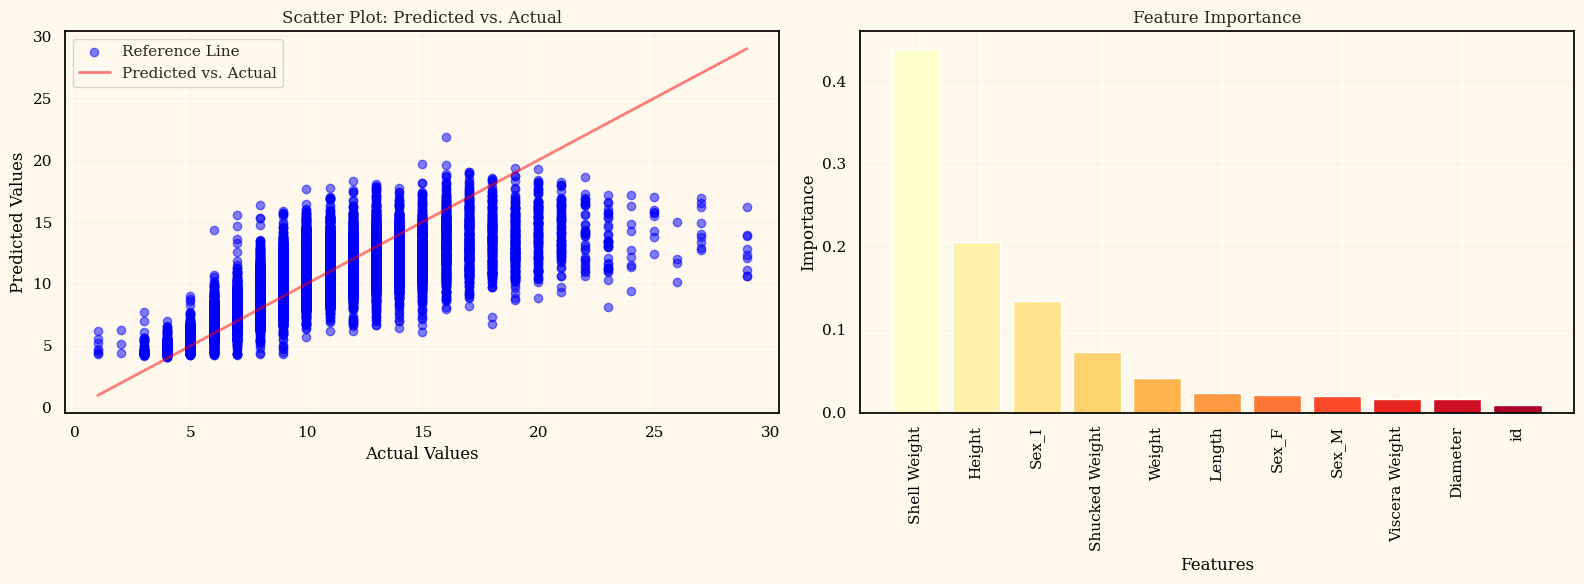

In [34]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Assuming importance_xgb contains the feature importances from the XGB model
# Assuming preds contains the predictions from the XGB model

# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plot of actual values vs predicted values
axes[0].scatter(Y_test, XGB_pred_1, color='blue', label='Actual', alpha=0.5)
axes[0].plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], color='red', alpha=0.5, linewidth=2)
axes[0].set_xlabel('Actual Values')
axes[0].set_ylabel('Predicted Values')
axes[0].set_title('Scatter Plot: Predicted vs. Actual')
axes[0].legend(['Reference Line', 'Predicted vs. Actual'])

# Feature Importance visualization
importance_xgb_avg = np.mean(importance_xgb, axis=0)
sorted_feature_indices = np.argsort(importance_xgb_avg)[::-1]
sorted_feature_names = [X.columns[i] for i in sorted_feature_indices]
sorted_importance = importance_xgb_avg[sorted_feature_indices]

color_map = cm.get_cmap('YlOrRd')
colors = color_map(np.arange(len(sorted_feature_names)) / len(sorted_feature_names))

axes[1].bar(range(len(sorted_feature_names)), sorted_importance, color=colors)
axes[1].set_xticks(range(len(sorted_feature_names)))
axes[1].set_xticklabels(sorted_feature_names, rotation='vertical')
axes[1].set_xlabel('Features')
axes[1].set_ylabel('Importance')
axes[1].set_title('Feature Importance')

plt.tight_layout()
plt.show()

### What to next to improve the model?
hyper-paramter tuning, feature selection, feature generation.... you can use these technics to upgrade your model!